# Project 1

In [15]:
import pandas as pd 
import numpy as np
import seaborn as sns
from numpy import linalg as la
from io import StringIO
from tabulate import tabulate
from matplotlib import pyplot as plt
import LinearModelsWeek2_ante as lm


In [16]:
# Load data
dat = pd.read_csv('firms.csv')
desired_years = [1968, 1969, 1970]
mask = dat['year'].isin(desired_years)

# Use the mask to filter the DataFrame
filtered_df = dat[mask]

#print(filtered_df)
#Check time period
filtered_df.year.unique()
print(filtered_df)



      firmid  year      lcap      lemp      ldsa
0          1  1968  0.998602 -0.242185  0.349053
1          1  1969  0.925214 -0.241278  0.312492
2          1  1970  0.879616 -0.265134  0.347566
12         2  1968 -0.069588 -0.323021 -0.945831
13         2  1969 -0.056724 -0.358177 -1.143830
...      ...   ...       ...       ...       ...
5269     440  1969 -0.228757  0.031242 -0.246864
5270     440  1970 -0.038354  0.062158 -0.345710
5280     441  1968 -1.618390 -1.944210 -2.032340
5281     441  1969 -1.635030 -1.856580 -2.011210
5282     441  1970 -1.454890 -1.538940 -1.371550

[1323 rows x 5 columns]


In [17]:
def demeaning_matrix(T):
    Q_T = np.identity(T) - (1/T) * np.ones((T,T))
    return Q_T

# Print the matrix
T = 3
Q_T = demeaning_matrix(T)
print(f'Demeaning matrix for T={T} \n', Q_T)

Demeaning matrix for T=3 
 [[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


In [92]:
y = filtered_df.ldsa.values
xi = []
ID = 0


for i in range(len(filtered_df)):
        if i%3 == 0: 
            yr = 1
        elif i%3 == 2:
            yr = 3
        else: 
            yr = 2
        if i%3 == 0: 
            ID = ID+1
       
        row = [ID, yr, filtered_df.lemp.values[i], filtered_df.lcap.values[i]]
        xi.append(row)

# Create a NumPy array from the list of rows for xi
xi = np.array(xi)

# Print the resulting NumPy arrays
print("xi:")
print(xi.shape)
print("y:")
yi = y.reshape(-1,1)
print(yi.shape)

#This code should work correctly with ldsa as the target variable, and it creates the xi NumPy array as described in your previous question.






#print(y.T)

xi:
(1323, 4)
y:
(1323, 1)


In [94]:
y_demean = lm.perm(Q_T,yi,t=T) # Why does it not work?
x_demean = lm.perm(Q_T,xi,t=T)

#print x_demean
print(x_demean)
print(y_demean)

[[ 1.11022302e-16 -1.00000000e+00  7.34733333e-03  6.41244000e-02]
 [ 1.11022302e-16  2.77555756e-16  8.25433333e-03 -9.26340000e-03]
 [ 1.11022302e-16  1.00000000e+00 -1.56016667e-02 -5.48610000e-02]
 ...
 [ 6.50035581e-14 -1.00000000e+00 -1.64300000e-01 -4.89533333e-02]
 [ 3.65818487e-14  2.77555756e-16 -7.66700000e-02 -6.55933333e-02]
 [ 3.26405569e-14  1.00000000e+00  2.40970000e-01  1.14546667e-01]]
[[ 0.0126826 ]
 [-0.0238781 ]
 [ 0.0111955 ]
 ...
 [-0.22730667]
 [-0.20617667]
 [ 0.43348333]]


In [95]:
def check_rank(x):
    print(f'Rank of demeaned x: {la.matrix_rank(x)}')
    lambdas, V = la.eig(x.T@x)
    np.set_printoptions(suppress=True)  # This is just to print nicely.
    print(f'Eigenvalues of within-transformed x: {lambdas.round(decimals=0)}')

# Check rank of demeaned x
check_rank(x_demean)

Rank of demeaned x: 3
Eigenvalues of within-transformed x: [  0. 882.   9.   5.]


In [96]:
pd.DataFrame(x_demean)

,0,1,2,3
0,1.110223e-16,-1.000000e+00,0.007347,0.064124
1,1.110223e-16,2.775558e-16,0.008254,-0.009263
2,1.110223e-16,1.000000e+00,-0.015602,-0.054861
3,2.220446e-16,-1.000000e+00,0.039549,-0.016591
4,2.220446e-16,2.775558e-16,0.004393,-0.003726
...,...,...,...,...
1318,5.551115e-14,2.775558e-16,-0.022075,-0.053239
1319,5.151435e-14,1.000000e+00,0.008840,0.137164
1320,6.500356e-14,-1.000000e+00,-0.164300,-0.048953
1321,3.658185e-14,2.775558e-16,-0.076670,-0.065593


In [109]:
x_demean_vars = (pd.DataFrame(x_demean[:,2:])).to_numpy()


label_x_fe = ['lemp', 'lcap']
N = 441
fe_result = lm.estimate(y_demean, x_demean_vars, N=N, T=T)
label_y = "ldsa"
# Print results
lm.print_table((label_y, label_x_fe), fe_result, title='FE regression', floatfmt='.4f')

FE regression
Dependent variable: ldsa

        Beta      Se    t-values
----  ------  ------  ----------
lemp  0.6004  0.0282     21.2592
lcap  0.0502  0.0312      1.6103
R² = 0.284
σ² = 0.005


In [ ]:
# Descriptive Statistics
filtered_df.describe()

,firmid,year,lcap,lemp,ldsa
count,1323.000000,1323.000000,1.323000e+03,1.323000e+03,1.323000e+03
mean,221.000000,1969.000000,-3.432577e-08,5.291005e-09,3.253968e-08
std,127.353547,0.816805,1.367661e+00,1.212370e+00,1.238870e+00
min,1.000000,1968.000000,-3.864950e+00,-3.108660e+00,-3.433130e+00
25%,111.000000,1968.000000,-9.629080e-01,-8.435585e-01,-9.082370e-01
50%,221.000000,1969.000000,-1.016350e-01,-1.141760e-01,-1.142770e-01
75%,331.000000,1970.000000,9.708763e-01,8.067791e-01,8.648864e-01
max,441.000000,1970.000000,3.993508e+00,3.187258e+00,3.418170e+00


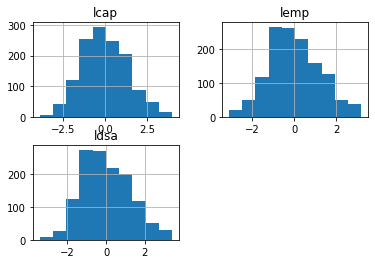

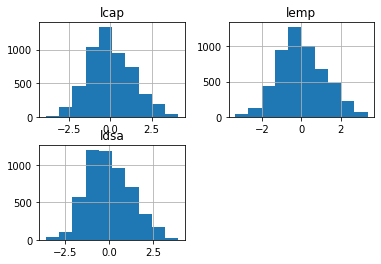

In [ ]:
filtered_df[['lcap', 'lemp', 'ldsa']].hist();
dat[['lcap', 'lemp', 'ldsa']].hist();


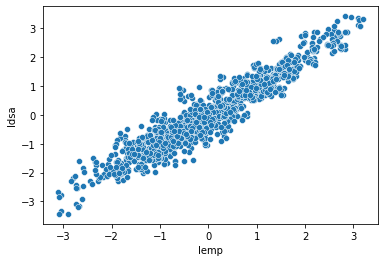

In [ ]:
sns.scatterplot(x = 'lemp', y = 'ldsa', data = filtered_df);

In [ ]:
# Convert to numpy format
filtered_df.ldsa.values.shape

(1323,)

In [ ]:
N = filtered_df.firmid.unique().size
T = filtered_df.year.unique().size
assert filtered_df.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

NameError: name 'filtered_df' is not defined

In [ ]:
# Extract data from pandas to numpy arrays
y = filtered_df.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = filtered_df.lemp.values.reshape((N*T,1))
k = filtered_df.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])